In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertModel, DistilBertTokenizer
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [2]:

# Extract text from file names as well as labels
def read_text_files_with_labels(path):
    texts = []
    labels = []
    class_folders = sorted(os.listdir(path))  # Assuming class folders are sorted
    label_map = {class_name: idx for idx, class_name in enumerate(class_folders)}

    for class_name in class_folders:
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            file_names = os.listdir(class_path)
            for file_name in file_names:
                file_path = os.path.join(class_path, file_name)
                if os.path.isfile(file_path):
                    file_name_no_ext, _ = os.path.splitext(file_name)
                    text = file_name_no_ext.replace('_', ' ')
                    text_without_digits = re.sub(r'\d+', '', text)
                    texts.append(text_without_digits)
                    labels.append(label_map[class_name])

    return np.array(texts), np.array(labels)

# Define your dataset class
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Define the model


class DistilBERTClassifier(nn.Module):

    def __init__(self, num_classes):

        super().__init__()

        self.distilbert = DistilBertModel.from_pretrained(
            "distilbert-base-uncased"
        )

        self.dropout = nn.Dropout(0.3)

        self.classifier = nn.Linear(
            self.distilbert.config.hidden_size,
            num_classes
        )

        # Freeze ALL DistilBERT layers initially
        for param in self.distilbert.parameters():
            param.requires_grad = False


    def forward(self, input_ids, attention_mask):

        outputs = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        cls_output = outputs.last_hidden_state[:, 0]

        x = self.dropout(cls_output)

        return self.classifier(x)
    
# Define training function
def train(model, iterator, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in iterator:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        output = model(input_ids, attention_mask)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(iterator)

# Define evaluation function
def evaluate(model, iterator, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in iterator:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            output = model(input_ids, attention_mask)
            loss = criterion(output, labels)

            total_loss += loss.item()

    return total_loss / len(iterator)

def predict(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    with torch.no_grad():  # Disable gradient tracking
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)  # Assuming input_ids are in the batch
            attention_mask = batch['attention_mask'].to(device)  # Assuming attention_mask is in the batch

            # Forward pass
            outputs = model(input_ids, attention_mask)

            # Get predictions
            _, preds = torch.max(outputs, dim=1)

            # Convert predictions to CPU and append to the list
            predictions.extend(preds.cpu().numpy())

    return predictions

In [3]:
TRAIN_PATH = r"C:\Users\john2\Desktop\uofc\617\assignment2\garbage_data\garbage_data\CVPR_2024_dataset_Train"
VAL_PATH = r"C:\Users\john2\Desktop\uofc\617\assignment2\garbage_data\garbage_data\CVPR_2024_dataset_Val"
TEST_PATH = r"C:\Users\john2\Desktop\uofc\617\assignment2\garbage_data\garbage_data\CVPR_2024_dataset_Test"

text_train,labels_train = read_text_files_with_labels(TRAIN_PATH)
text_val,labels_val = read_text_files_with_labels(VAL_PATH)
text_test,labels_test = read_text_files_with_labels(TEST_PATH)

print(text_train.shape)
print(labels_train.shape)
print(text_val.shape)
print(labels_val.shape)
print(text_test.shape)
print(labels_test.shape)

(11629,)
(11629,)
(1800,)
(1800,)
(3432,)
(3432,)


In [10]:
# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenize data
max_len = 24
dataset_train = CustomDataset(text_train, labels_train, tokenizer, max_len)
dataset_val = CustomDataset(text_val, labels_val, tokenizer, max_len)
dataset_test = CustomDataset(text_test, labels_test, tokenizer, max_len)

# Data loaders
train_loader = DataLoader(dataset_train, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=8, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=8, shuffle=False)


# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DistilBERTClassifier(num_classes=4).to(device)

# Training parameters
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

best_loss = float("inf")
EPOCHS = 6

for epoch in range(EPOCHS):

    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    # Stage freezing logic
    if epoch == 0:
        print("Training classifier only")

    elif epoch == 2:
        print("Unfreezing last 2 transformer layers")
        for layer in model.distilbert.transformer.layer[-2:]:
            for param in layer.parameters():
                param.requires_grad = True
        optimizer = optim.AdamW(
            filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5
        )

    elif epoch == 4:
        print("Unfreezing last 4 transformer layers")
        for layer in model.distilbert.transformer.layer[-4:-2]:
            for param in layer.parameters():
                param.requires_grad = True
        optimizer = optim.AdamW(
            filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5
        )
    elif epoch == 5:
        print("Unfreezing last 4 transformer layers")
        for layer in model.distilbert.transformer.layer:
            for param in layer.parameters():
                param.requires_grad = True
        optimizer = optim.AdamW(
            filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5
        )

    ####################
    # TRAIN
    ####################
    model.train()
    train_loss = 0

    for batch in train_loader:

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    ####################
    # VALIDATE
    ####################
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for batch in val_loader:

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask)

            loss = criterion(outputs, labels)

            val_loss += loss.item()

    val_loss /= len(val_loader)

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")

    ####################
    # SAVE BEST MODEL
    ####################
    if val_loss < best_loss:

        best_loss = val_loss
        torch.save(model.state_dict(), "best_text_model.pth")

        torch.save(model, "best_text_model_full.pth")

        print("✅ Full model saved")

        


Epoch 1/6
Training classifier only
Train Loss: 1.3125
Val Loss: 1.2294
✅ Full model saved

Epoch 2/6
Train Loss: 1.2167
Val Loss: 1.1498
✅ Full model saved

Epoch 3/6
Unfreezing last 2 transformer layers
Train Loss: 0.5003
Val Loss: 0.3816
✅ Full model saved

Epoch 4/6
Train Loss: 0.3492
Val Loss: 0.3308
✅ Full model saved

Epoch 5/6
Unfreezing last 4 transformer layers
Train Loss: 0.3082
Val Loss: 0.3121
✅ Full model saved

Epoch 6/6
Unfreezing last 4 transformer layers
Train Loss: 0.2671
Val Loss: 0.3001
✅ Full model saved


In [11]:
# Load model
model = torch.load(
    "best_text_model_full.pth",
    map_location=device,
    weights_only=False
)

model = model.to(device)
model.eval()

# Set evaluation mode
model.eval()

# Move model to device
model.to(device)

# Run prediction
test_predictions = predict(model, test_loader, device)

# Calculate accuracy
accuracy = (test_predictions == labels_test).sum() / len(labels_test)

print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8531


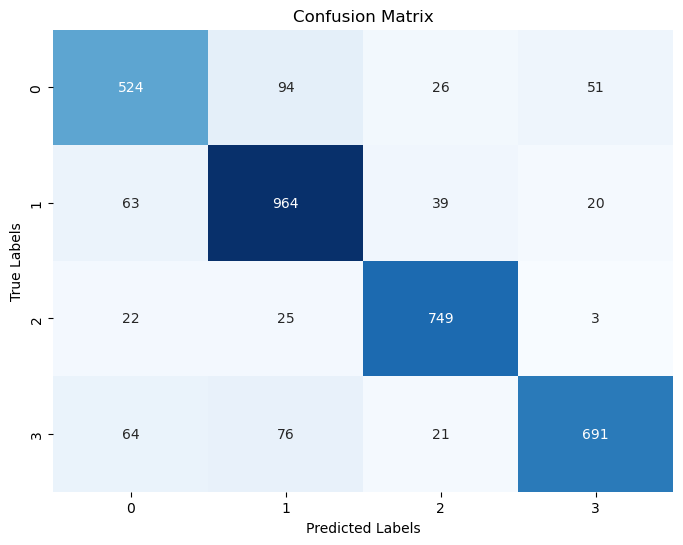

In [9]:
cm = confusion_matrix(labels_test, test_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()